# 回归预测分析

在本篇文章中，主要是介绍利用波士顿房价数据来掌握回归预测分析的一些方法。通过本篇文章你可以学习到：

- 可视化数据集的重要特征
- 估计回归模型的系数
- 使用RANSAC你和高鲁棒性回归模型
- 如何来评价回归模型
- 多项式回归
- 决策树回归
- 随机森林回归

掌握数据的基本情况

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#设置seaborn的风格
sns.set(style="whitegrid",context="notebook")

if __name__ == "__main__":
    #读取数据集
    data = pd.read_table("housing.data", delim_whitespace=True)
    #获取csv的前5行数据
    print(data.head(5))

      crim    zn  indus  chas    nox     rm   age     dis  rad    tax  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   ptratio   black  lstat  medv  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


## 一、数据特征的可视化
探索性数据分析(Exploratory Data Analysis，EDA)：是机器学习模型训练之前的一个重要步骤，通过借助python第三方库pandas、seaborn来绘图，可以帮助我们分析和发现数据中的异常情况、数据的分布情况，以及特征将的相互关系。

由于屏幕大小关系，我们选择四个自变量和因变量进行分析，indus(房屋所在镇无零售业务区域所占比例)，nox(一氧化氮浓度，每千万分之一)，rm(每处寓所的平均房间数)，lstat(弱势群体人口所占比例)，medv(房屋平均价格，单位1000美元)。

### 1、绘制散点图

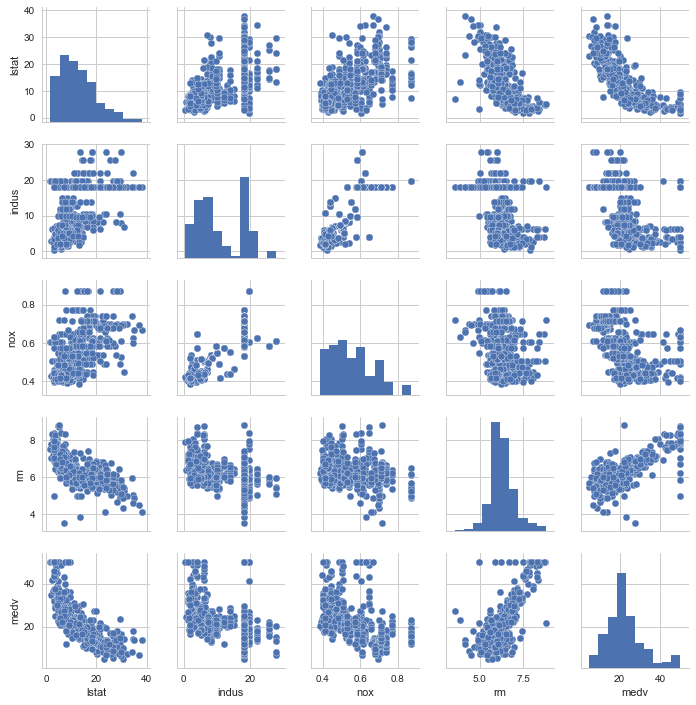

In [11]:
#选择需要绘制散点图的列名
cols = ["lstat","indus","nox","rm","medv"]
#通过seaborn绘制散点图
sns.pairplot(data[cols],size=2)
plt.show()

通过绘制特征的散点图，我们可以发现变量之间的关系。对角线是变量的直方图，可以看出特征的分布情况。通过medv(房价)的直方图可以发现，房价服从正态分布，但是在大于40的部分包含了几个异常值。通过rm(房间数)和medv(房价)的散点图，第四行第五列，呈线性分布。而其他的三个变量与mdv(房价)呈一个非线性分布。

注意：训练一个线性回归模型并不需要自变量或者因变量呈正态分布，正态假设仅适用于某些统计检验和假设检验。

### 2、系数矩阵

除了通过变量之间的散点图来寻找变量之间的关系，还可以通过变量之间的相关系数来发现变量的关系。相关系数矩阵，常用的有皮尔逊相关系数(Pearson product-moment correlation coefficient，Pearson's r)的方阵，通过它可以来衡量两个特征之间的线性关系。皮尔逊相关系数的取值在[-1,1]范围内，如果r=1，表示两个变量呈正相关，r=0表示两个变量没有关系，r=-1表示两个变量呈负相关。其实，相关系数矩阵就是标准化的协方差矩阵。

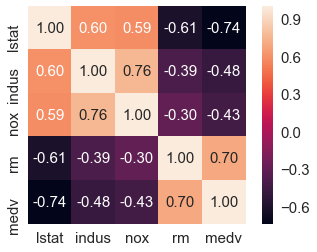

In [12]:
#获取相关系数矩阵
cm = np.corrcoef(data[cols].values.T)
#设置字的比例
sns.set(font_scale=1.5)
#绘制相关系数图
hm = sns.heatmap(cm,cbar=True,annot=True,square=True,fmt=".2f",
                 annot_kws={"size":15},yticklabels=cols,xticklabels=cols)
plt.show()

通过相关系数矩阵可以发现，lstat与medv的相关性最大(-0.74)，其次就是rm与medv的相关性最大。通过之前的散点图，也可以说明这一点。

## 二、常用的线性回归算法
分析rm与medv的线性关系
### 1、线性回归

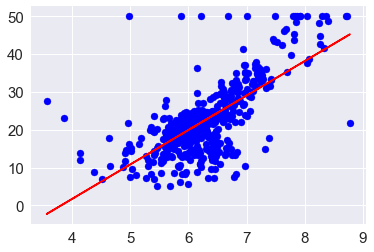

In [13]:
#获取特征和目标变量的值
X = data["rm"]
Y = data["medv"]
from sklearn.linear_model import LinearRegression
#创建一个线性模型对象
linear = LinearRegression()
X = np.array(X).reshape(506,1)
Y = np.array(Y).reshape(506,1)
#训练模型
linear.fit(X,Y)
#绘制点
plt.scatter(X, Y, c="blue")
#绘制直线
pred_Y = linear.predict(X)
plt.plot(X,pred_Y,c="red")
plt.show()

In [14]:
X = data["rm"]
type(X)
X = np.array(X).reshape(506,1)
type(X)

numpy.ndarray

通过rm与medv数据之间的关系，来拟合一条直线。通过rm与medv的点集可以发现，在周围存在着很多的异常值，异常值对于线性回归模型具有很严重的影响。下面通过RANSAC算法，清除异常值。

### 2、RANSAC拟合高鲁棒性回归

RANSAC(Random Sample Consenus)，它是根据一组包含异常数据的样本数据集，计算出数据的数学模型参数，得到有效样本数据的算法。使用数据的一个子集(内点,Ran)来进行回归模型的拟合。

RANSAC算法的工作流程如下：

1、从数据集中随机抽取样本构建内点集合拟合模型。

2、使用剩余的数据对上一步得到的模型进行测试，并将落在预定公差范围内的样本点增加到内点集合中。

3、使用全部的内点集合数据再次进行模型的拟合。

4、使用内点集合来估计模型的误差。

5、如果模型性能达到了用户设定的特定阈值或者迭代的次数达到了预定的次数，则算法终止，否则重复从第一步开始。

In [15]:
#乱码问题解决办法
#coding:utf-8
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号
#有中文出现的情况，需要u'内容'

F:\installed_soft\Anaconda3\lib\site-packages\sklearn\linear_model\ransac.py:288: DeprecationWarning: 'residual_metric' was deprecated in version 0.18 and will be removed in version 0.20. Use 'loss' instead.
  DeprecationWarning)


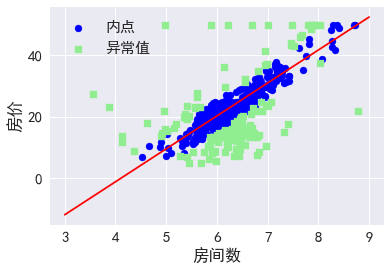

In [16]:
from sklearn.linear_model import RANSACRegressor
'''
max_trials设置最大迭代次数为100
min_samples随机抽取内点的最小样本数为50
residual_metric计算拟合曲线与样本点的距离的绝对值
residual_threshold设置预定公差，小于这个值才被加入到内点集合
'''
ransac = RANSACRegressor(LinearRegression(),max_trials=100,min_samples=50,
                         residual_metric=lambda x:np.sum(np.abs(x),axis=1),
                         residual_threshold=5.0,random_state=0)
ransac.fit(X,Y)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)
line_X = np.arange(3,10,1)
line_y_ransac = ransac.predict(line_X[:,np.newaxis])
plt.scatter(X[inlier_mask],Y[inlier_mask],c="blue",marker="o",label=u'内点')
plt.scatter(X[outlier_mask],Y[outlier_mask],c="lightgreen",marker="s",label=u'异常值')
plt.plot(line_X,line_y_ransac,color="red")
plt.xlabel(u'房间数')
plt.ylabel(u'房价')
plt.legend(loc="upper left")
plt.show()

## 三、线性回归模型性能的评估
### 1、残差图
通过绘制残差图能够直观的发现真实值与预测值之间的差异或垂直距离，通过真实值与预测值之间的差异来对回归模型进行评估。残差图可以作为图形分析方法，可以对回归模型进行评估、获取模型的异常值，同时还可以检查模型是否是线性的，以及误差是否随机分布。

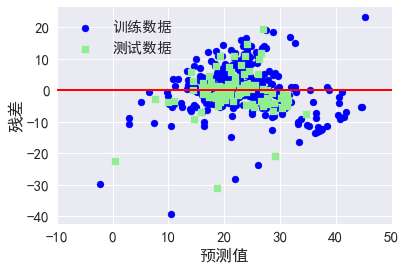

In [17]:

#获取特征和目标变量的值
X = data["rm"]
Y = data["medv"]
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
# #创建一个线性模型对象
linear = LinearRegression()
X = np.array(X).reshape(506,1)
Y = np.array(Y).reshape(506,1)
# #训练模型
linear.fit(X,Y)
#将数据集分为训练集和测试集
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.2)
train_y_pred = linear.predict(train_x)
test_y_pred = linear.predict(test_x)
plt.scatter(train_y_pred,train_y_pred-train_y,c="blue",marker="o",label="训练数据")
plt.scatter(test_y_pred,test_y_pred-test_y,c="lightgreen",marker="s",label="测试数据")
plt.legend(loc="upper left")
plt.hlines(y=0,xmin=-10,xmax=50,lw=2,color="red")
plt.xlim([-10,50])
plt.xlabel("预测值")
plt.ylabel("残差")
plt.show()

最好的模型预测结果的残差为0，在实际应用中，这种情况是不可能发生的。但是，对于一个好的模型，我们期望误差是随机分布的，同时残差也是在y=0水平线附近波动。通过残差图也可以发现异常值，偏离y=0比较远的点。

### 2、均方误差(MSE)
均方误差(Mean Squared Error，MSE)：真实值与预测值差的平方和的平均值，计算公式如下

<center>$MSE=\frac{1}{n}\sum_{i=1}^{n}(y_i-\widehat{y}_i)^2$</center>

In [18]:
from sklearn.metrics import mean_squared_error
print("train MSE:%.3f"%mean_squared_error(train_y,train_y_pred))
#train MSE:46.037
print("test MSE:%.3f"%mean_squared_error(test_y,test_y_pred))
#test MSE:35.919

train MSE:44.106
test MSE:41.597


### 3、决定系数$R^2$

在某些情况下决定系数(coefficient of determination)$R^2$非常重要，可以将其看成一个MSE标准化版本，$R^2$是模型捕获响应方差的分数。对于训练集来说，$R^2$的取值范围为[0,1]，对于测试集来说，$R^2$取值可能为负。如果$R^2$越接近与1表明其模型的性能越好。$R^2$计算公式如下：
<center>$R^2=1-\frac{\frac{1}{n}\sum_{i=1}^{n}(y_i-\widehat{y}_i)^2}{\frac{1}{n}\sum_{i=1}^{n}(y_i-u_i)^2}=1-\frac{MSE}{Var(y)}$</center>


In [19]:
from sklearn.metrics import r2_score
print("train r2:%.3f"%r2_score(train_y,train_y_pred))
#train r2:0.473
print("test r2:%.3f"%r2_score(test_y,test_y_pred))
#test r2:0.485

train r2:0.506
test r2:0.362


## 四、非线性回归
### 1、多项式回归
对于不满足线性回归，可以通过加入多项式来使用多项式回归。

<center>$y=\omega_0+\omega_1x+\omega_2x^2+\cdots+\omega_nx^n $</center>

前面通过散点图绘制了四个特征与房价之前关系，发现lstat与房价之间呈现一个非线性关系，我们分别使用线性回归于多项式回归来拟合lstat与房价之间的线性关系，对比$R^2$的变化。

linear R^2:0.544
polynomial R^2:0.641


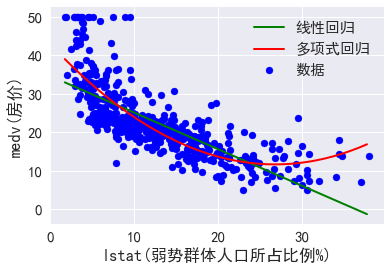

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

#线性回归
X = np.array(data["lstat"]).reshape(506,1)
Y = np.array(data["medv"]).reshape(506,1)
linear = LinearRegression()
linear.fit(X,Y)
linear_y = linear.predict(X)
print("linear R^2:%.3f"%r2_score(Y,linear_y))
#linear R^2:0.546

#多项式回归
qua_linear = LinearRegression()
#设置x的最大次数为2
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)
qua_linear.fit(X_quad,Y)
qua_linear_y = qua_linear.predict(X_quad)
print("polynomial R^2:%.3f"%r2_score(Y,qua_linear_y))
#polynomial R^2:0.641

#绘点
plt.scatter(X,Y,label=u'数据',marker="o",color="blue")
X_linear = np.arange(np.min(X),np.max(X),1)[:,np.newaxis]
#线性回归
plt.plot(X_linear,linear.predict(X_linear),label=u'线性回归',
         color="green",lw=2,linestyle="-")
#多项式拟合
plt.plot(X_linear,qua_linear.predict(quadratic.fit_transform(X_linear))
         ,label=u'多项式回归',color="red",lw=2,linestyle="-")
plt.xlabel(u'lstat(弱势群体人口所占比例%)')
plt.ylabel(u'medv(房价)')
plt.legend(loc="upper right")
plt.show()

### 2、特征转换
对于这种非线性回归除了使用多项式回归还可以使用log回归。对于lstat与medv之间的关系，可以先将lstat进行log对数转换，medv进行平方根转换之后再使用线性回归。

R^2:0.670


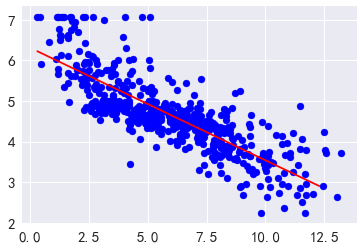

In [24]:
#特征转换
X_log = np.log(X)
Y_sqrt = np.sqrt(Y)
linear = LinearRegression()
linear.fit(X_log,Y_sqrt)
print("R^2:%.3f"%r2_score(Y_sqrt,linear.predict(X_log)))
#R^2:0.692

plt.scatter(X_log,Y_sqrt,label=u'数据',marker="o",color="blue")
lin_X = np.arange(np.min(X_log),np.max(X_log),1)[:,np.newaxis]
plt.plot(lin_X,linear.predict(lin_X),label=u'线性拟合',linestyle="-",color="red")
plt.show()

通过上图可以发现，将特征转换之后由原来的非线性关系变成了线性关系，而且R^2比多项回归的结果还要好。

### 3、随机森林
随机森林是一种集成算法，它是通过组合多棵决策树。能够降低模型的方差，与单棵决策树相比，随机森林通常具有更好的泛化性能。它对数据集中的异常值不敏感，不需要过多的参数调优。

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#将数据集分为测试集和训练集
train_x,test_x,train_y,test_y = train_test_split(X,Y,test_size=0.3)
'''
n_estimators:估计器(树)的个数
criterion:优化目标
'''
forest = RandomForestRegressor(n_estimators=100,criterion="mse",n_jobs=1)
forest.fit(train_x,train_y)
print("train r2:%.3f"%r2_score(train_y,forest.predict(train_x)))
#train r2:0.929
print("test r2:%.3f"%r2_score(test_y,forest.predict(test_x)))
#test r2:0.227

train r2:0.928
test r2:0.447


F:\installed_soft\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


通过上面的结果可以发现，随机森林存在过拟合。